In [1]:
from os import listdir, path
import numpy as np
import scipy, cv2, os, sys, argparse, audio
import json, subprocess, random, string
from tqdm import tqdm
from glob import glob
import torch, face_detection
from models import Wav2Lip
import platform

from matplotlib import pyplot as plt
import cv2

In [2]:
img_size = 96
checkpoint_path = 'checkpoints/wav2lip_gan.pth'
static = True

In [3]:
def face_detect(images, video, nosmooth=True):
    detector = face_detection.FaceAlignment(face_detection.LandmarksType._2D, 
                                            flip_input=False, device=device)

    batch_size = 16
    
    while 1:
        predictions = []
        try:
            for i in tqdm(range(0, len(images), batch_size)):
                predictions.extend(detector.get_detections_for_batch(np.array(images[i:i + batch_size]), video))
        except RuntimeError:
            if batch_size == 1: 
                raise RuntimeError('Image too big to run face detection on GPU. Please use the --resize_factor argument')
            batch_size //= 2
            print('Recovering from OOM error; New batch size: {}'.format(batch_size))
            continue
        break

    if static:
        face = predictions[0][0]
        predictions = [face]
    else:
        tmp = []
        for pred in predictions:
            face = pred[0]
            tmp.append(face)
        predictions = tmp
        
    results = []
    pady1, pady2, padx1, padx2 = [0, 10, 0, 0]
    
    for rect, image in zip(predictions, images):
        if rect is None:
            cv2.imwrite('temp/faulty_frame.jpg', image) # check this frame where the face was not detected.
            raise ValueError('Face not detected! Ensure the video contains a face in all the frames.')

        y1 = max(0, rect[1] - pady1)
        y2 = min(image.shape[0], rect[3] + pady2)
        x1 = max(0, rect[0] - padx1)
        x2 = min(image.shape[1], rect[2] + padx2)
        plt.imshow(image[y1: y2, x1:x2])
        plt.show()
        results.append([x1, y1, x2, y2])

    boxes = np.array(results)
    if not nosmooth: boxes = get_smoothened_boxes(boxes, T=5)
    results = [[image[y1: y2, x1:x2], (y1, y2, x1, x2)] for image, (x1, y1, x2, y2) in zip(images, boxes)]
    image, box = results[0]
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    del detector
    return results 

In [12]:
def datagen(frames, mels, static=True):
    img_batch, mel_batch, frame_batch, coords_batch = [], [], [], []

    box = [-1, -1, -1, -1]
    if box[0] == -1:
        if not static:
            # The following is returned from face_detect: [image[y1: y2, x1:x2], (y1, y2, x1, x2)]
            face_det_results = face_detect(frames, True) # BGR2RGB for CNN face detection
        else:
            face_det_results = face_detect([frames[0]], False)
            #print(face_det_results)
    else:
        print('Using the specified bounding box instead of face detection...')
        y1, y2, x1, x2 = box
        face_det_results = [[f[y1: y2, x1:x2], (y1, y2, x1, x2)] for f in frames]

    for i, m in enumerate(mels):
        idx = 0 if static else i%len(frames)
        frame_to_save = frames[idx].copy()
        face, coords = face_det_results[idx].copy()

        face = cv2.resize(face, (img_size, img_size))
        
        img_batch.append(face)
        mel_batch.append(m)
        frame_batch.append(frame_to_save)
        coords_batch.append(coords)

        if len(img_batch) >= 128:
            img_batch, mel_batch = np.asarray(img_batch), np.asarray(mel_batch)
            

            img_masked = img_batch.copy()
            plt.imshow(cv2.cvtColor(img_masked[0], cv2.COLOR_BGR2RGB))
            plt.show()
            # Mask the bottom half of the picture (this is the part that needs to be generated)
            img_masked[:, img_size//2:] = 0

            img_batch = np.concatenate((img_masked, img_batch), axis=3) / 255.
            mel_batch = np.reshape(mel_batch, [len(mel_batch), mel_batch.shape[1], mel_batch.shape[2], 1])
            #print(img_batch[0])
            plt.imshow(cv2.cvtColor(img_masked[0], cv2.COLOR_BGR2RGB))
            plt.show()

            yield img_batch, mel_batch, frame_batch, coords_batch
            img_batch, mel_batch, frame_batch, coords_batch = [], [], [], []

    if len(img_batch) > 0:
        img_batch, mel_batch = np.asarray(img_batch), np.asarray(mel_batch)

        img_masked = img_batch.copy()
        img_masked[:, img_size//2:] = 0

        img_batch = np.concatenate((img_masked, img_batch), axis=3) / 255.
        mel_batch = np.reshape(mel_batch, [len(mel_batch), mel_batch.shape[1], mel_batch.shape[2], 1])

        yield img_batch, mel_batch, frame_batch, coords_batch

In [5]:
def _load(checkpoint_path):
    if device == 'cuda':
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path,
                                map_location=lambda storage, loc: storage)
    return checkpoint

In [6]:
def load_model(path):
    model = Wav2Lip()
    print("Load checkpoint from: {}".format(path))
    checkpoint = _load(path)
    s = checkpoint["state_dict"]
    new_s = {}
    for k, v in s.items():
        new_s[k.replace('module.', '')] = v
    model.load_state_dict(new_s)

    model = model.to(device)
    return model.eval()

In [7]:
def main(face, audiof, resize_factor=0):
    if not os.path.isfile(face):
        raise ValueError('--face argument must be a valid path to video/image file')

    elif face.split('.')[1] in ['jpg', 'png', 'jpeg']:
        full_frames = [cv2.imread(face)]
        fps = 25

    else:
        video_stream = cv2.VideoCapture(face)
        fps = video_stream.get(cv2.CAP_PROP_FPS)

        print('Reading video frames...')

        full_frames = []
        while 1:
            still_reading, frame = video_stream.read()
            if not still_reading:
                video_stream.release()
                break
            if resize_factor > 1:
                frame = cv2.resize(frame, (frame.shape[1]//resize_factor, frame.shape[0]//resize_factor))

            #if args.rotate:
                #frame = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)

            y1, y2, x1, x2 = [0, -1, 0, -1]
            if x2 == -1: x2 = frame.shape[1]
            if y2 == -1: y2 = frame.shape[0]

            frame = frame[y1:y2, x1:x2]

            full_frames.append(frame)

    print ("Number of frames available for inference: "+str(len(full_frames)))
    

    if not audiof.endswith('.wav'):
        print('Extracting raw audio...')
        command = 'ffmpeg -y -i {} -strict -2 {}'.format(audiof, 'temp/temp.wav')

        subprocess.call(command, shell=True)
        audiof = 'temp/temp.wav'

    wav = audio.load_wav(audiof, 16000)
    mel = audio.melspectrogram(wav)
    print(mel.shape)

    if np.isnan(mel.reshape(-1)).sum() > 0:
        raise ValueError('Mel contains nan! Using a TTS voice? Add a small epsilon noise to the wav file and try again')

    mel_chunks = []
    mel_idx_multiplier = 80./fps 
    i = 0
    while 1:
        start_idx = int(i * mel_idx_multiplier)
        if start_idx + mel_step_size > len(mel[0]):
            mel_chunks.append(mel[:, len(mel[0]) - mel_step_size:])
            break
        mel_chunks.append(mel[:, start_idx : start_idx + mel_step_size])
        i += 1

    print("Length of mel chunks: {}".format(len(mel_chunks)))

    full_frames = full_frames[:len(mel_chunks)]

    batch_size = 16
    gen = datagen(full_frames.copy(), mel_chunks)
    #print(next(gen))

    for i, (img_batch, mel_batch, frames, coords) in enumerate(tqdm(gen, 
                                            total=int(np.ceil(float(len(mel_chunks))/batch_size)))):
        if i == 0:
            model = load_model(checkpoint_path)
            print ("Model loaded")

            frame_h, frame_w = full_frames[0].shape[:-1]
            out = cv2.VideoWriter('temp/result.avi', 
                                    cv2.VideoWriter_fourcc(*'DIVX'), fps, (frame_w, frame_h))

        img_batch = torch.FloatTensor(np.transpose(img_batch, (0, 3, 1, 2))).to(device)
        mel_batch = torch.FloatTensor(np.transpose(mel_batch, (0, 3, 1, 2))).to(device)

        with torch.no_grad():
            pred = model(mel_batch, img_batch)

        pred = pred.cpu().numpy().transpose(0, 2, 3, 1) * 255.

        for p, f, c in zip(pred, frames, coords):
            y1, y2, x1, x2 = c
            
            p = cv2.resize(p.astype(np.uint8), (x2 - x1, y2 - y1))

            f[y1:y2, x1:x2] = p
            plt.imshow(p)
            #plt.show()
            out.write(f)

    out.release()

    command = 'ffmpeg -y -i {} -i {} -strict -2 -q:v 1 {}'.format(audio, 'temp/result.avi', 'result.mp4')
    subprocess.call(command, shell=platform.system() != 'Windows')

In [8]:
mel_step_size = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

  0%|          | 0/33 [00:00<?, ?it/s]

Number of frames available for inference: 1
(80, 1694)
Length of mel chunks: 526



100%|██████████| 1/1 [00:00<00:00, 19.42it/s]


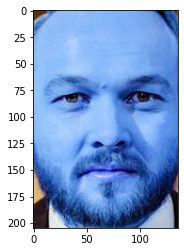

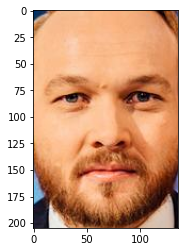

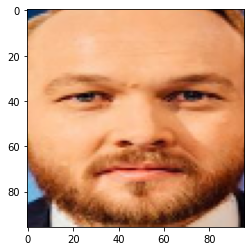

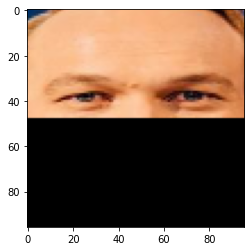

Load checkpoint from: checkpoints/wav2lip_gan.pth
Model loaded


  0%|          | 0/33 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [13]:
main('data/lubach2.jpeg', 'data/speech.wav')

Reading video frames...
Number of frames available for inference: 3543
(80, 1694)
Length of mel chunks: 1259


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Recovering from OOM error; New batch size: 8



100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


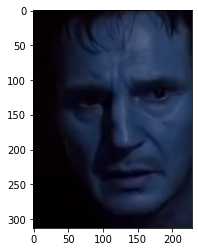

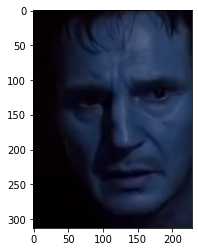

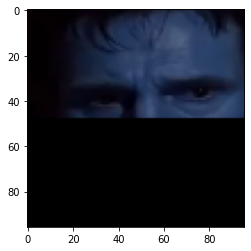

Load checkpoint from: checkpoints/wav2lip_gan.pth
Model loaded


In [ ]:
main('data/taken.mp4', 'data/speech.wav')

  0%|          | 0/33 [00:00<?, ?it/s]

Number of frames available for inference: 1
(80, 1694)
Length of mel chunks: 526



100%|██████████| 1/1 [00:00<00:00, 65.92it/s]


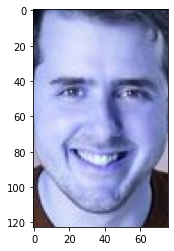

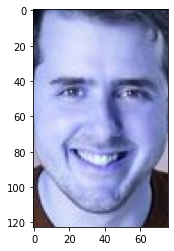

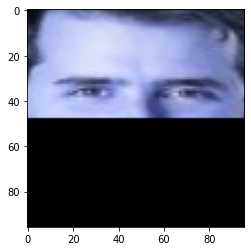

Load checkpoint from: checkpoints/wav2lip_gan.pth
Model loaded


  3%|▎         | 1/33 [00:01<00:46,  1.44s/it]

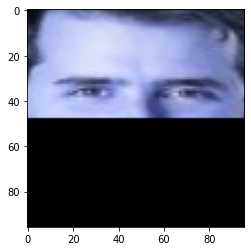

  6%|▌         | 2/33 [00:02<00:42,  1.38s/it]

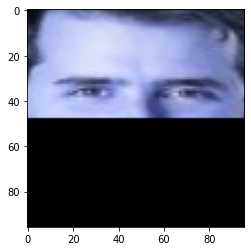

  9%|▉         | 3/33 [00:03<00:40,  1.34s/it]

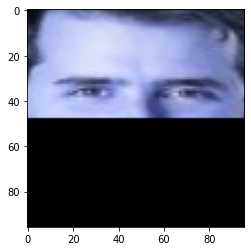

 15%|█▌        | 5/33 [00:05<00:29,  1.05s/it]


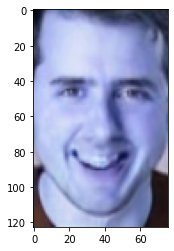

In [56]:
main('data/Deevid.jpg', 'data/speech.wav')

  0%|          | 0/33 [00:00<?, ?it/s]

Number of frames available for inference: 1
(80, 1694)
Length of mel chunks: 526



100%|██████████| 1/1 [00:00<00:00, 102.51it/s]


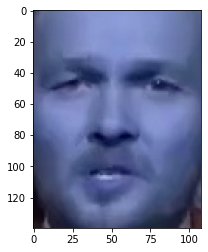

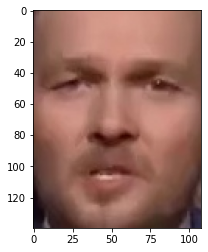

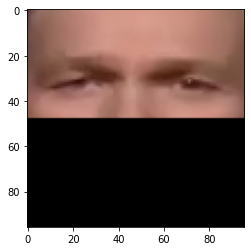

Load checkpoint from: checkpoints/wav2lip_gan.pth
Model loaded


  3%|▎         | 1/33 [00:01<00:44,  1.38s/it]

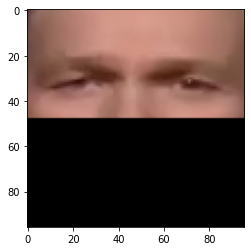

  6%|▌         | 2/33 [00:02<00:43,  1.39s/it]

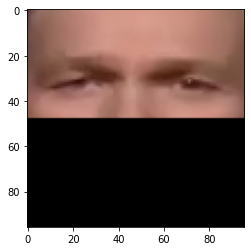

  9%|▉         | 3/33 [00:04<00:43,  1.45s/it]


KeyboardInterrupt: 

In [20]:
main('filelists/0/0001/0.jpg', 'data/speech.wav')